# Ames Housing Price Prediction

## Regression

In this notebook, I will explore various normal and regularised regression models to determine an effective model for predicting house prices in Ames, Iowa.

## Import and clean

In [178]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [179]:
# load the data
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')

In [180]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [181]:
# Number of null records
print('Num null values in training set:', np.sum(train.isnull().sum()))
print('Num null values in test set:', np.sum(test.isnull().sum()))

train.isnull().sum().sort_values(ascending=False).apply(lambda x: x / len(train)).head(5)

Num null values in training set: 6965
Num null values in test set: 7000


PoolQC         0.995205
MiscFeature    0.963014
Alley          0.937671
Fence          0.807534
FireplaceQu    0.472603
dtype: float64

In [182]:
test.isnull().sum().sort_values(ascending=False).apply(lambda x: x / len(test)).head(5)

PoolQC         0.997944
MiscFeature    0.965045
Alley          0.926662
Fence          0.801234
FireplaceQu    0.500343
dtype: float64

In [183]:
def cols_startswith(columns, value, exclude=[]):
    return [x for x in columns if x.startswith(value) and x not in exclude]

def clean(df):
    # All except FireplaceQu >80% missing values
    cols = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu']
    df[cols] = df[cols].fillna('None')

    # ~50% missing values - fill with mean
    df['LotFrontage'] = df['LotFrontage'].fillna(df['LotFrontage'].mean())

    # Garage
    garage_num_cols = ['GarageArea', 'GarageCars']
    garage_cols = cols_startswith(df.columns, 'Garage', garage_num_cols)
    df[garage_cols] = df[garage_cols].fillna('None')
    for x in garage_num_cols:
        df[x] = df[x].fillna(df[x].mean())
    
    # Basement
    basement_num_cols = ['BsmtUnfSF', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath']
    basement_cols = cols_startswith(df.columns, 'Bsmt', basement_num_cols)
    df[basement_cols] = df[basement_cols].fillna('None')
    df[basement_num_cols] = df[basement_num_cols].fillna(0)

    # MasVnr
    df['MasVnrType'] = df['MasVnrType'].fillna('None')
    df['MasVnrArea'] = df['MasVnrArea'].fillna(0)

    # For remaining columns, if numerical fill with mean, if categorical/string/object fill with most common
    remaining_null_cols = df.columns[df.isnull().any()]
    for x in remaining_null_cols:
        if df[x].dtype in (np.float64, np.int64):
            df[x] = df[x].fillna(df[x].mean())
        else:
            df[x] = df[x].fillna(df[x].mode().iloc[0])

    return df

In [184]:
train, test = clean(train), clean(test)

print('Num null values in training set:', np.sum(train.isnull().sum()))
print('Num null values in test set:', np.sum(test.isnull().sum()))

Num null values in training set: 0
Num null values in test set: 0


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,4.110874,RL,4.189655,9.042040,Pave,None,Reg,Lvl,AllPub,Inside,...,0.0,None,None,None,0.000000,2,2008,WD,Normal,2.583824
1,3.044522,RL,4.394449,9.169623,Pave,None,Reg,Lvl,AllPub,FR2,...,0.0,None,None,None,0.000000,5,2007,WD,Normal,2.573300
2,4.110874,RL,4.234107,9.328212,Pave,None,IR1,Lvl,AllPub,Inside,...,0.0,None,None,None,0.000000,9,2008,WD,Normal,2.589054
3,4.262680,RL,4.110874,9.164401,Pave,None,IR1,Lvl,AllPub,Corner,...,0.0,None,None,None,0.000000,2,2006,WD,Abnorml,2.553297
4,4.110874,RL,4.442651,9.565284,Pave,None,IR1,Lvl,AllPub,FR2,...,0.0,None,None,None,0.000000,12,2008,WD,Normal,2.597433
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,4.110874,RL,4.143135,8.976894,Pave,None,Reg,Lvl,AllPub,Inside,...,0.0,None,None,None,0.000000,8,2007,WD,Normal,2.570514
1456,3.044522,RL,4.454347,9.486152,Pave,None,Reg,Lvl,AllPub,Inside,...,0.0,None,MnPrv,None,0.000000,2,2010,WD,Normal,2.584365
1457,4.262680,RL,4.204693,9.109746,Pave,None,Reg,Lvl,AllPub,Inside,...,0.0,None,GdPrv,Shed,2.177526,5,2010,WD,Normal,2.602181
1458,3.044522,RL,4.234107,9.181735,Pave,None,Reg,Lvl,AllPub,Inside,...,0.0,None,None,None,0.000000,4,2010,WD,Normal,2.554469


In [185]:
# Drop useless ID column
train = train.drop('Id', axis=1)

## Target variable

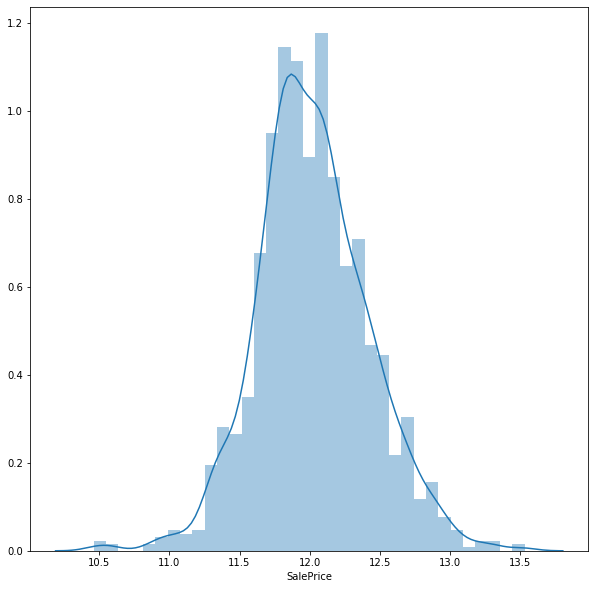

In [186]:
# Log transform SalePrice

train['SalePrice'] = np.log1p(train['SalePrice'])

plt.figure(figsize=(10,10))
sns.distplot(train['SalePrice'])

## EDA and feature transformation



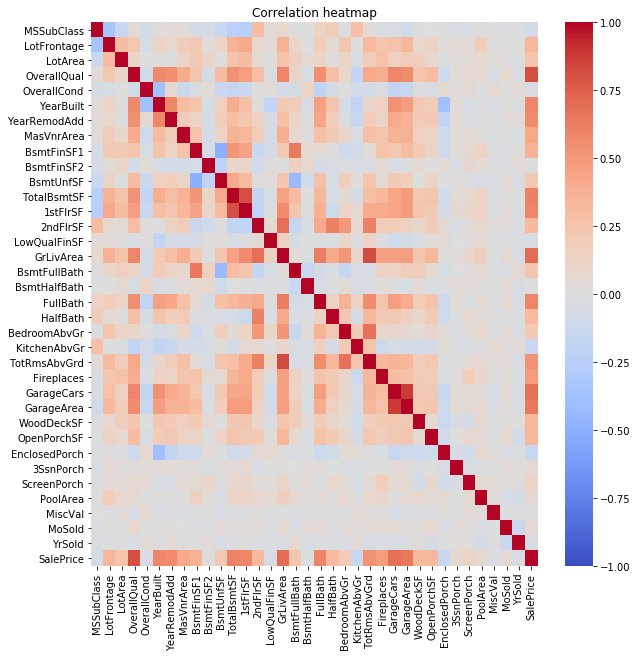

In [187]:
overall_corr = train.corr()
saleprice_corr = overall_corr[['SalePrice']].sort_values(by='SalePrice', ascending=False)

plt.figure(figsize=(10,10))
sns.heatmap(overall_corr, cmap='coolwarm', vmax=1, vmin=-1).set_title('Correlation heatmap')
plt.show()

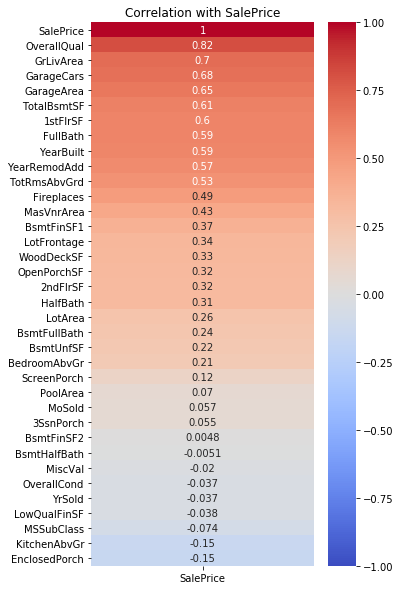

In [188]:
plt.figure(figsize=(5,10))
sns.heatmap(saleprice_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1).set_title('Correlation with SalePrice')
plt.show()

There are a number of features that correlate well with SalePrice, which are good for a regression model, however there is a decent degree of multicolinearity which can cause model coefficients to become statistically insignificant as it increases the coefficient standard errors.

In [189]:
from scipy.stats import skew

# Log transforming skewed features
numerical_columns = [x for x in train.columns if train[x].dtype in (np.float64, np.int64)]

skewed_cols = train[numerical_columns].apply(lambda x: skew(x))
skewed_cols = skewed_cols[skewed_cols > 0.75].index

train[skewed_cols] = train[skewed_cols].apply(np.log1p)
test[skewed_cols] = test[skewed_cols].apply(np.log1p) # also apply to test set

In [190]:
# Create one hot encoded features
all_data = pd.concat([train, test])
all_data = pd.get_dummies(all_data)

X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]

X_train = X_train.drop('Id', axis=1)

# Separate y
y = X_train['SalePrice']
X_train = X_train.drop('SalePrice', axis=1)

## Model

Firstly, I will explore common regression algorithms and how they perform with repeated-cross validation.

In [191]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.model_selection import cross_val_score

models = {}

# Linear regression
models['linear'] = LinearRegression()

# Lasso
lasso = LassoCV(alphas=np.logspace(-5, 3, 100))
lasso.fit(X_train, y)
best_alpha = lasso.alpha_
models['lasso'] = Lasso(alpha=best_alpha)

# Ridge
ridge = RidgeCV(alphas=np.logspace(-5, 3, 100))
ridge.fit(X_train, y)
best_alpha = ridge.alpha_
models['ridge'] = Ridge(alpha=best_alpha)

# ElasticNet
elasticnet = ElasticNetCV(alphas=np.logspace(-5, 3, 100))
elasticnet.fit(X_train, y)
best_alpha = elasticnet.alpha_
models['elasticnet'] = ElasticNet(alpha=best_alpha)

In [192]:
from sklearn.utils import shuffle

def cv_rmse(model_dict):
    results = {}
    for model in model_dict.keys():
        # X_res, y_res = shuffle(X_train, y)
        res = -cross_val_score(model_dict[model], X_train, y, cv=10, scoring='neg_root_mean_squared_error')
        results[model] = res
    return results

results = pd.DataFrame(cv_rmse(models))

linear: 2746043.4437
lasso: 0.1213
ridge: 0.1256
elasticnet: 0.1217

Linear regression:
0    1.314640e-01
1    1.150720e-01
2    1.235441e-01
3    1.696989e-01
4    1.486447e-01
5    2.213948e-01
6    1.297989e-01
7    1.118554e-01
8    2.746043e+07
9    1.422787e-01
Name: linear, dtype: float64 

linear without outlier 0.1438


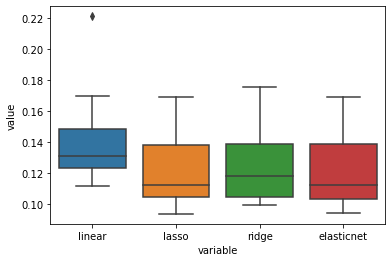

In [193]:
for x in results.columns:
    print(str(x) + ':', round(np.mean(results[x]), 4))

print('\nLinear regression:')
print(results['linear'], '\n')

outlier = results['linear'] > 1
print('linear without outlier', round(np.mean(results['linear'][~outlier]), 4))

results['linear'][8] = np.nan

sns.boxplot(x='variable', y='value', data=pd.melt(results))

We can see that linear regression had quite an outlier RMSE value on one of the folds. Even if we filter this out, the average MSE of linear regression is still higher than the regularised methods. This suggests there are noisy features in the data set and that regularisation is effective at removing this noise. Lasso regression performed the best across all folds, with ElasticNet only slightly worse. It seems that L1 regularisation and its potential to force coefficients to zero is slightly better for this task.

Let's also see how an XGB regression model performs across 10 fold validation with a random hyperparameter search.

### XGBoost

In [102]:
from scipy import stats
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import root_mean_squared_error

clf_xgb = XGBRegressor(objective='reg:squarederror', early_stopping_rounds=5, nthread=-1)
param_dist = {
    'eta': [20],
    'max_depth': [x for x in range(3,11)],
    'gamma': stats.uniform(0, 20),
    'alpha': stats.uniform(0, 1),
    'subsample': stats.uniform(0.3, 0.7),
    'colsample_bytree': stats.uniform(0.2, 0.7)
}

clf = RandomizedSearchCV(clf_xgb, param_distributions=param_dist, scoring='neg_mean_squared_error', n_jobs=-1, n_iter=5, verbose=0)

folds = KFold(n_splits=10, shuffle=True)

estimators, scores = [], []
for train_index, val_index in folds.split(X_train):
    xgb_train, xgb_val = X_train.iloc[train_index,:], X_train.iloc[val_index,:]
    y_train, y_val = y.iloc[train_index].values.ravel(), y.iloc[val_index].values.ravel()
    clf.fit(xgb_train, y_train, eval_set=[(xgb_val, y_val)], verbose=False)

    estimators.append(clf.best_estimator_)
    scores.append(root_mean_squared_error(y_val, clf.predict(xgb_val)))

xgboost: 0.0341


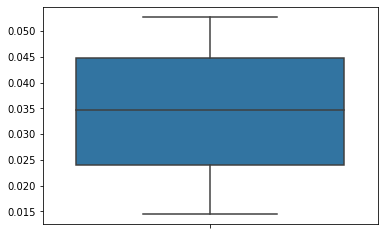

In [105]:
print('xgboost:', round(np.mean(scores), 4))

sns.boxplot(scores, orient='v')

We can see that XGBoost does not perform particularly well for this task. This could be due to the random fold selection, however even the lowest value is close to Lasso regression's mean RMSE.

## Final prediction

For the final test set prediction and submission to Kaggle, I will use the Lasso regression model with ~0.0005 alpha based on the cross-validation results.

In [177]:
final_model = models['lasso']
final_model.fit(X_train, y)

test_ids = X_test['Id']
test_df = X_test.drop(['SalePrice', 'Id'], axis=1)

preds = final_model.predict(test_df)

results = pd.DataFrame({'Id': test_ids.astype(int), 'SalePrice': np.expm1(preds)})
results.to_csv('submission.csv', index=False)

## Results

After submitting these results to Kaggle, I received a public score of 0.12196 (RSME) putting me in the top 20% of submissions. This is very similar to the mean cross-validation score across the training set for the Lasso model, which suggests that the test set that Kaggle uses for the leaderboard is similar to the training set distribution.

To improve my result, my first step would be feature engineering and outlier removal. It was clear from the linear regression RMSE values that there is some subset of the data with a massive value swing compared to the rest of the whole training set. Combining various related columns to produce interaction terms and mapping appropriate one hot encoded categories to ordinal scales may uncover more underlying information.

I would also look into implementing some form of ensemble bagging. A collection of regression models trained on varying bootstrapped subsets of the data could explain more variance of the test set in aggregate than a single model.